In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from joblib import Parallel, delayed

In [2]:
plt.rcParams['font.size'] = 7
plt.rcParams['svg.fonttype'] = 'none'

In [ ]:
accession_assemblies = pd.read_parquet('../data/ecoli/interim/unique_accession_assemblies.pq')
accession_clusters = pd.read_table('../data/ecoli/interim/seq_clusters.txt', names=['cluster_id', 'product_accession'])

In [ ]:
assembly_clusters_df = (accession_assemblies.merge(accession_clusters, how='inner', on='product_accession')
                        [['cluster_id', 'assembly']].drop_duplicates())

In [ ]:
cluster_count = assembly_clusters_df['cluster_id'].value_counts()

In [ ]:
assemblies = assembly_clusters_df['assembly'].drop_duplicates()
n_assemblies = len(assemblies)

In [ ]:
n_assemblies

3000

In [ ]:
len(cluster_count)

71334

In [ ]:
(cluster_count <= 10).sum()

56883

In [ ]:
(cluster_count >= 2990).sum()

1673

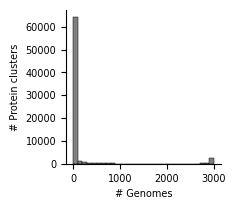

In [ ]:
plt.subplots(figsize=(2,2))
sns.histplot(cluster_count, binwidth=100, color='grey', alpha=1)
sns.despine()
plt.xlabel('# Genomes')
plt.ylabel('# Protein clusters')
plt.savefig('../figures/e_coli_strains_u_plot.svg', dpi=300, bbox_inches='tight')

In [ ]:
assemblies = assembly_clusters_df['assembly'].drop_duplicates()

In [24]:
def sample_clusters(n, n_boot, assemblies, assembly_clusters_df):
    out_list = list()
    for boot in range(n_boot):
        sampled_assemblies = assemblies.sample(n=n, random_state=boot).to_list()
        n_clusters = assembly_clusters_df.loc[assembly_clusters_df['assembly'].isin(sampled_assemblies), 
                                              'cluster_id'].nunique()
        out_dict = {'n_assemblies': n,
                    'n_clusters': n_clusters, 
                    'boot': boot}
        out_list.append(out_dict)
    out_df = pd.DataFrame(out_list)
    return out_df

In [25]:
n_samples = [int(x) for x in np.linspace(1, 3_000, num=50)]
n_boot = 50

In [26]:
out_df_list = Parallel(n_jobs=40)(delayed(sample_clusters)(n, n_boot, assemblies, assembly_clusters_df) for n in tqdm(n_samples))

100%|██████████| 50/50 [00:00<00:00, 404.11it/s]


In [ ]:
out_df = pd.concat(out_df_list)

In [54]:
agg_out_df = (out_df.groupby('n_assemblies')
              .agg({'n_clusters': 'mean'})
              .reset_index())

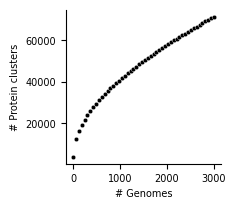

In [55]:
plt.subplots(figsize=(2, 2))
sns.scatterplot(data=agg_out_df, x='n_assemblies', y='n_clusters',
                color='black', s=10)
sns.despine()
plt.xlabel('# Genomes')
plt.ylabel('# Protein clusters')
plt.savefig('../figures/ecoli_gene_clusters_per_assembly.svg', dpi=300, bbox_inches='tight')